In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
#https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb#scrollTo=a2vvHeFgVtCp

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import subprocess
import time
import pyautogui
import pygetwindow as gw


In [5]:
path_to_tws = r"C:\Jts\tws.exe"  # Or launch.exe


In [2]:
# Path to the TWS launcher or IB Gateway
path_to_tws = r"C:\Users\proso\OneDrive\Pulpit\Trader Workstation.lnk"  # Or launch.exe

subprocess.Popen(path_to_tws, shell=True)


def check_if_app_open(app_name):
    windows = gw.getAllTitles()
    for title in windows:
        if title.strip():
            if app_name in title:
                print(f"Found window with title: {title}")
                time.sleep(2)  # Wait a bit for the window to be ready
                return True
login_open = False
while not login_open:
    login_open = check_if_app_open("Login")
    time.sleep(1)    

# --- Focus TWS window ---
for i in range(10):
    windows = gw.getWindowsWithTitle('Login')
    if windows:
        windows[0].activate()
        break
    time.sleep(1)

# --- Type credentials ---
time.sleep(2)
pyautogui.write("prosolukasz")
pyautogui.press('tab')
pyautogui.write("Ferrari0234!INTERACTIVE")
pyautogui.press('enter')

ib_open = False
while not ib_open:
    ib_open = check_if_app_open("Interactive Brokers")
    time.sleep(1)

Found window with title: Login
Found window with title: DUK343627 Interactive Brokers (Simulated Trading)


In [30]:
from source.IB_connector import retrive_market_data

ticker = "AAPL"
training_set_aapl = retrive_market_data([ticker], duration = "1 Y", time_interval = "15 mins")
training_set = training_set_aapl[ticker]
training_set['Volume'] = training_set['Volume'].astype(float)
training_set['Date'] = pd.to_datetime(training_set['Date'].str.replace(' US/Eastern',''),format="%Y%m%d %H:%M:%S")

ERROR -1 2104 Market data farm connection is OK:usfarm.nj
ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR -1 2106 HMDS data farm connection is OK:ushmds
ERROR -1 2158 Sec-def data farm connection is OK:secdefil


Found window with title: DUK343627 Interactive Brokers (Simulated Trading)


NameError: name 'pd' is not defined

In [29]:
training_set.head()

,Date,Open,High,Low,Close,Volume
0,20240605 09:30:00 US/Eastern,194.53,195.51,193.96,194.48,3809462.0
1,20240605 09:45:00 US/Eastern,194.48,194.93,194.14,194.87,2105915.0
2,20240605 10:00:00 US/Eastern,194.84,194.92,194.10,194.51,1663574.0
3,20240605 10:15:00 US/Eastern,194.52,194.80,194.12,194.47,1425444.0
4,20240605 10:30:00 US/Eastern,194.47,194.86,194.35,194.47,1189549.0


In [5]:
col_select = ['Open','High','Low','Close','Volume']
training_set = training_set[col_select]
training_set.dtypes
CLOSE_INDEX = col_select.index('Close')

In [ ]:
n = len(training_set)
train_df = training_set[0:int(n*0.4)]
val_df = training_set[int(n*0.4):int(n*0.5)]
rl_df = training_set[int(n*0.5):int(n*0.9)]
test_df = training_set[int(n*0.9):]

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

In [113]:
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std


In [14]:
from torch.utils.data import Dataset, DataLoader
from source.LSTMdataset import WindowDataset, WindowGenerator

OUT_STEPS = 16


w1 = WindowGenerator(input_width=48, label_width=OUT_STEPS, shift=OUT_STEPS, 
                    train_df=train_df, val_df=val_df, test_df=test_df, 
                    label_columns=['Close'])
# Stworzenie datasetu:
train_dataset = w1.make_dataset(train_df.values)  # Zakładając, że train_df to np. pandas.DataFrame
val_dataset = w1.make_dataset(val_df.values)  # Zakładając, że train_df to np. pandas.DataFrame

# DataLoader:
BATCH_SIZE = 512 # 256 * 2 = 512
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [15]:
from LSTMmodel import MultiLSTMModel, MAPELoss
num_epochs = 2000
learning_rate = 0.014

num_features = 5
input_size = num_features
lstm = MultiLSTMModel(input_size=input_size, lstm_units=32, out_steps=OUT_STEPS, num_features=num_features)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm.to(device)

MultiLSTMModel(
  (lstm): LSTM(5, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
)

In [16]:
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
criterion = MAPELoss()

for epoch in range(num_epochs):
  
    for inputs, labels in train_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = lstm(inputs)
      optimizer.zero_grad()
      loss = criterion(outputs, labels)
      
      loss.backward()
      
      optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))



Epoch: 0, loss: 76.80549
Epoch: 100, loss: 34.85324
Epoch: 200, loss: 26.12741
Epoch: 300, loss: 20.22377
Epoch: 400, loss: 19.03428
Epoch: 500, loss: 23.31374
Epoch: 600, loss: 23.78202
Epoch: 700, loss: 22.12694
Epoch: 800, loss: 15.86193
Epoch: 900, loss: 19.32492
Epoch: 1000, loss: 19.37522
Epoch: 1100, loss: 23.53400
Epoch: 1200, loss: 36.80445
Epoch: 1300, loss: 35.09927
Epoch: 1400, loss: 34.63352
Epoch: 1500, loss: 28.88641
Epoch: 1600, loss: 78.63317
Epoch: 1700, loss: 52.63768
Epoch: 1800, loss: 75.48611
Epoch: 1900, loss: 78.41327


In [ ]:
#torch.save(lstm.state_dict(), 'appl_15min_8m_LSTM.pth')

In [18]:
i = 0 
for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = lstm(inputs)
    
    loss = criterion(outputs, labels)    
    leb = labels.detach().cpu().numpy()*train_std[3] + train_mean[3]
    pred = outputs.detach().cpu().numpy()*train_std[3] + train_mean[3]
    print(loss.item())
    print("MAPE ", np.mean(np.abs(leb - pred) / leb * 100) )
    print("MAE ", np.mean(np.abs(leb - pred)) )


98.77770233154297
MAPE  0.7596467
MAE  1.7397949
147.2374267578125
MAPE  0.6922043
MAE  1.576273


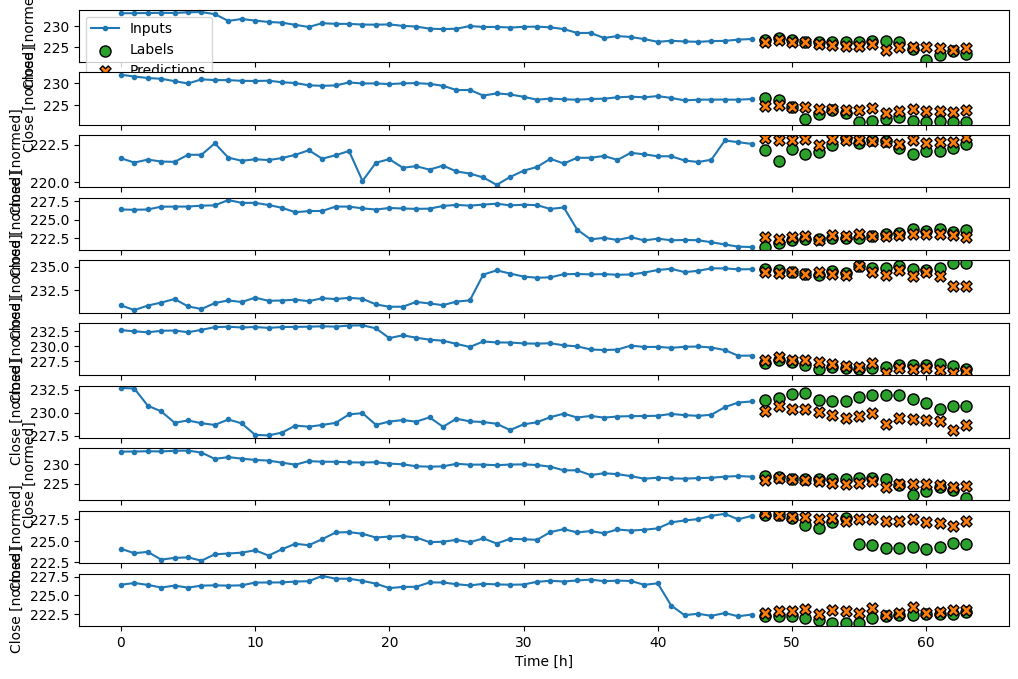

In [19]:
inpu = inputs.detach().cpu().numpy()*train_std[CLOSE_INDEX] + train_mean[CLOSE_INDEX]

w1.example = inpu, leb

w1.plot(pred, max_subplots=10)

In [87]:
from enviroments import TimeSeriesEnvFuturePredict
env = TimeSeriesEnvFuturePredict(data=rl_df['Close'].values, lstm=lstm,lstm_data=rl_df.values,device=device,
                                 train_std = train_std[CLOSE_INDEX],train_mean= train_mean[CLOSE_INDEX], window_size=48, future_size=OUT_STEPS)

In [22]:
from rl_agent import DQNAgent, train_episode

agent = DQNAgent(observation_space=env.observation_space.shape[0], action_space=env.action_space.n)

In [108]:
from tqdm import tqdm

epsilon = 1
EPISODES = 102
# Iterate over episodes
for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):
    train_episode(agent,env, episode, 0.9)



  2%|1         | 2/102 [00:34<28:53, 17.33s/episodes]


KeyboardInterrupt: 

In [141]:
from rl_agent import save_dqn_agent

save_dqn_agent(agent, 'aapl_15min_norm.pth')

In [132]:
ticker = "INTC"
other_ticker = retrive_market_data([ticker], duration = "1 M", time_interval = "15 mins")
other_ticker = other_ticker[ticker]
other_ticker['Volume'] = other_ticker['Volume'].astype(float)
other_ticker['Date'] = pd.to_datetime(other_ticker['Date'].str.replace(' US/Eastern',''),format="%Y%m%d %H:%M:%S")
other_ticker = other_ticker[col_select]
#other_ticker = (other_ticker - other_ticker.mean()) / other_ticker.std()


ERROR -1 2104 Market data farm connection is OK:usfarm.nj
ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR -1 2106 HMDS data farm connection is OK:ushmds
ERROR -1 2158 Sec-def data farm connection is OK:secdefil


In [133]:
# test_env = TimeSeriesEnvFuturePredict(data=test_df['Close'].values, lstm=lstm,lstm_data=test_df.values,device=device,
#                                  train_std = train_std[CLOSE_INDEX],train_mean= train_mean[CLOSE_INDEX], window_size=48, future_size=OUT_STEPS)

In [134]:
test_env = TimeSeriesEnvFuturePredict(data=other_ticker['Close'].values, lstm=lstm,lstm_data=other_ticker.values,device=device,
                                 train_std = other_ticker.std()[CLOSE_INDEX],train_mean= other_ticker.mean()[CLOSE_INDEX], window_size=48, future_size=OUT_STEPS)

In [135]:
test_env._get_observation()

array([-2.044, -2.261, -2.282, -2.38 , -2.326, -2.369, -2.499, -2.499,
       -2.673, -2.662, -2.521, -2.499, -2.445, -2.521, -2.521, -2.521,
       -2.499, -2.565, -2.467, -2.38 , -2.326, -2.348, -2.326, -2.315,
       -2.196, -2.055, -1.436, -1.599, -1.415, -1.36 , -1.382, -1.241,
       -1.111, -1.263, -1.425, -1.241, -1.154, -1.143, -1.23 , -1.274,
       -1.36 , -1.501, -1.393, -1.469, -1.393, -1.328, -1.36 , -1.284,
       -0.431, -0.401, -0.369, -0.396, -0.441, -0.492, -0.442, -0.496,
       -0.461, -0.56 , -0.46 , -0.532, -0.428, -0.447, -0.433, -0.513],
      dtype=float32)

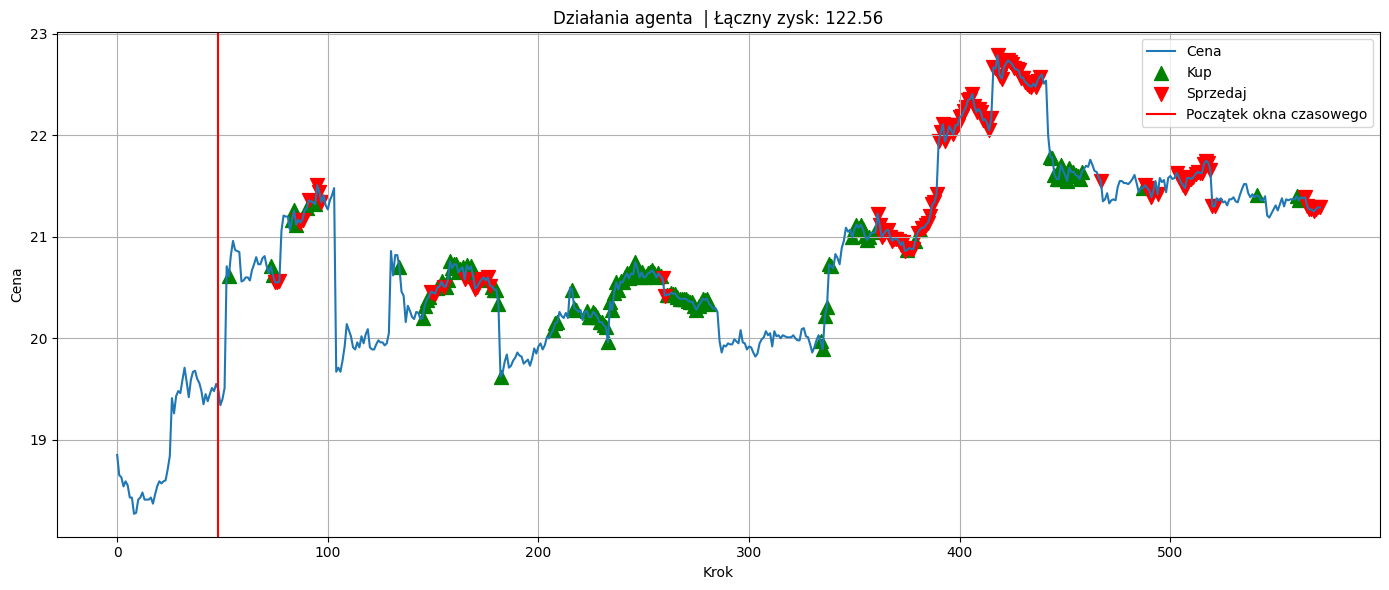

In [144]:
from eval_models import evaluate_steps, render_env

test_env.reset()
evaluate_steps(test_env, agent.target_model)
render_env(test_env, title_suffix="")

In [137]:
sum(test_env.inventory) - len(test_env.inventory) * test_env.data[-1]

2.639999999999958

In [138]:
np.sum(test_env.data[-1] - test_env.inventory) 

-2.6400000000000112

In [139]:
test_env.data[-1]

21.29

In [140]:
test_env.inventory

[21.64,
 21.64,
 21.61,
 21.6,
 21.57,
 21.64,
 21.48,
 21.41,
 21.4,
 21.36,
 21.39,
 21.38]